In [1]:
from visualization.show_bbox import show_two_bounding_boxes
import cv2 
import json 
import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms
from data.torch_data_loaders import homography_dataset
from board_detection.homomography_network import HomographyNet
import tqdm

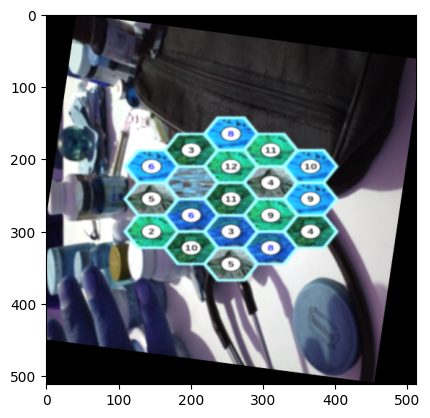

In [2]:
with open('data/full/perspective_distorted_boards/bbox_coordinates.json', 'r') as f:
    data = json.load(f)

img_name = "canvas_image_9.png"
bbox = data[img_name]
homography_matrix = data[f"{img_name}_homography_matrix"]
img = cv2.imread(f"data/full/perspective_distorted_boards/{img_name}")

# show_two_bounding_boxes(bbox, bbox, img)

inverse_matrix = np.linalg.inv(homography_matrix)
affine_matrix = inverse_matrix[:2, :]

(h, w) = img.shape[:2]

transformed_image = cv2.warpAffine(img, affine_matrix, (w, h))
plt.imshow(transformed_image)
plt.show()

100%|██████████| 4/4 [00:27<00:00,  6.76s/it]


Epoch [1/3], Loss: 1354.3555


100%|██████████| 4/4 [00:25<00:00,  6.42s/it]


Epoch [2/3], Loss: 1053.7034


100%|██████████| 4/4 [00:25<00:00,  6.36s/it]


Epoch [3/3], Loss: 647.1310


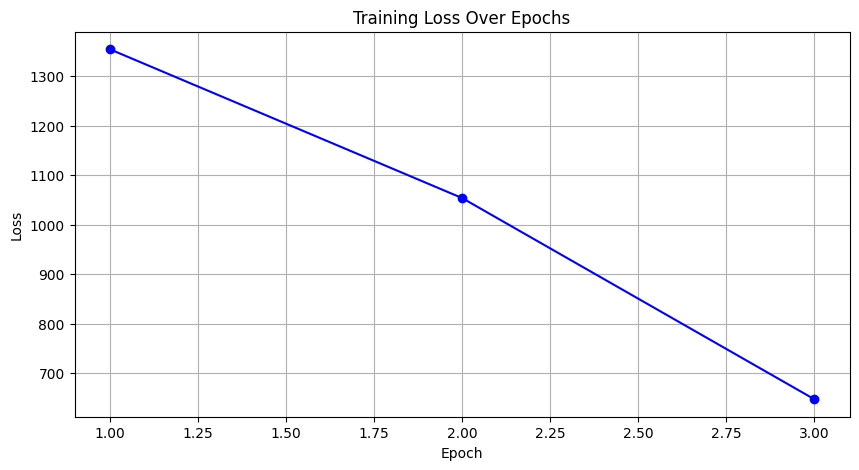

In [3]:
transform_pipeline = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor()
])

output_pipeline = transforms.Compose([
    homography_dataset.HomographyOutputTransform((512, 512), (128, 128)),
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)), 
    transforms.Lambda(lambda x: torch.flatten(x))
])


batch_size = 32
learning_rate = 0.001
num_epochs = 3
json_path = 'data/full/perspective_distorted_boards/bbox_coordinates.json'
img_dir = "data/full/perspective_distorted_boards"

with open(json_path, 'r') as f:
    data = json.load(f)

dataset = homography_dataset.HomographyDataset(json_path, img_dir, input_transform=transform_pipeline, output_transform=output_pipeline)
train_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# Create PyTorch datasets and loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = HomographyNet(9)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in tqdm.tqdm(train_loader):
        # Move tensors to GPU if available
        inputs, labels = inputs, labels
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [28]:
image, label = dataset.__getitem__(1)
matrix = model(image.unsqueeze(0))


image = image.squeeze().detach().numpy()

print(label)
print(matrix)

label, matrix = label.detach().numpy().reshape(3, 3), matrix.detach().numpy().reshape(3, 3)

tensor([ 2.8946e+00, -1.9736e+00,  1.6564e+02,  1.5131e+00,  3.7490e+00,
        -8.0775e+01, -1.1906e-09, -5.8102e-10,  1.0000e+00])
tensor([[ 2.5013e+00,  3.2114e-01,  5.2976e+01,  2.6223e-01,  1.6383e+00,
         -4.1924e+01, -1.5592e-02,  1.8791e-01,  1.0666e+00]],
       grad_fn=<AddmmBackward0>)


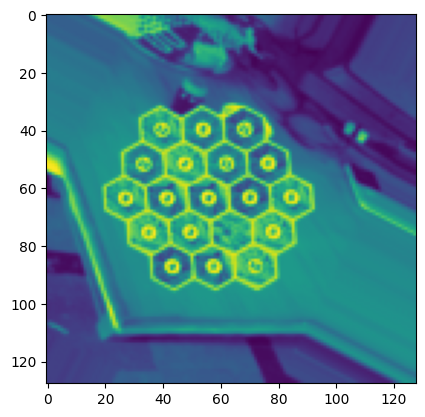

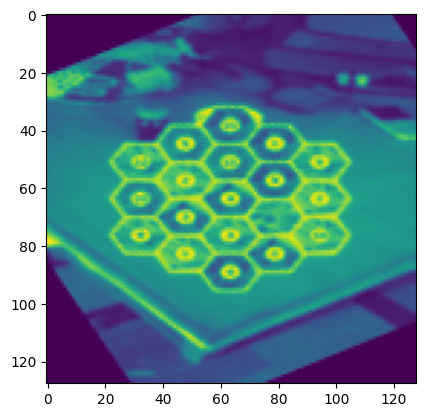

In [30]:
inverse_matrix = np.linalg.inv(label) 
scaling_matrix = np.array([[4, 0, 0], [0, 4, 0], [0, 0, 1]])
inverse_matrix = inverse_matrix @ scaling_matrix

# print(np.dot(np.array(data[f"canvas_image_200.png_homography_matrix"]), scaling_matrix @ np.linalg.inv(scaling_matrix))
# print(label)
# print(scaling_matrix)
(h, w) = image.shape[:2]

plt.imshow(image)
plt.show()

transformed_image = cv2.warpPerspective(image, inverse_matrix , (w, h))
plt.imshow(transformed_image)
plt.show()



[[0.8053774218312283, -0.5573865746195159, 178.47434738746253],
 [0.4406565083135537, 1.0209635790839329, -117.94393911154151],
 [-6.631693634012697e-11, 5.836884631594808e-11, 1.0]]